In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# jax
import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.base import param_field, static_field

import jax
from jax import jit, config, hessian, grad
from jax import config
from jaxtyping import (
    Float,
)
import jax.random as jr
import jax.numpy as jnp
import optax as ox

from dataclasses import dataclass, field


# from kernels import WaveKernel

from beartype.typing import Union
import tensorflow_probability.substrates.jax.bijectors as tfb

config.update("jax_enable_x64", True)
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(42)
key, subkey = jr.split(key)

KeyboardInterrupt: 

In [ ]:
########################################## edit the parameters here ##########################################

# define the parameters of the model
dt = 0.001

# define noise, which is the variance of the noise in the data
noise = 0.001

# number of test points
n_test = 31
n_boundary = 2

In [ ]:
# read data from testdata/wave_eqn.json
with open('../../testdata/wave_eqn.json','r') as f:
    data = json.load(f)
    datax = jnp.array(data['x'])
    datau = jnp.array(data['u'])
    datav = jnp.array(data['v'])

#add noise 
u_noise, v_noise = noise, 0
U_true = datau
V_true = datav

U = datau + np.sqrt(u_noise) * jr.normal(subkey, datau.shape)
V = datav + np.sqrt(v_noise) * jr.normal(subkey, datav.shape)
x = datax


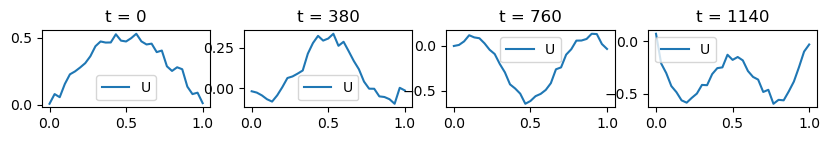

In [ ]:
# plot U at t = 0, 380, 760, 1140
fig, ax = plt.subplots(1,4, figsize=(10,1))
ax = ax.flatten()
for i, t_val in enumerate([0, 380, 760, 1140]):
    ax[i].plot(x, U[t_val], label="U")
    # ax[i].plot(x, V[t_val], label="V")
    ax[i].set_title(f"t = {t_val}")
    ax[i].legend()
plt.show()

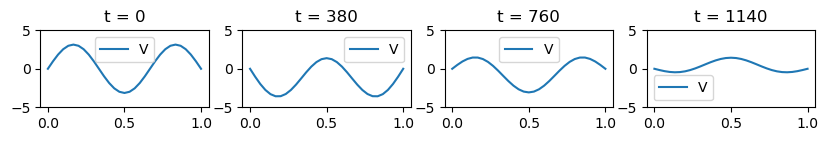

In [ ]:
# plot V at t = 0, 380, 760, 1140
fig, ax = plt.subplots(1,4, figsize=(10,1))
ax = ax.flatten()
for i, t_val in enumerate([0,380,760,1140]):
    ax[i].plot(x, V[t_val], label="V")
    ax[i].set_title(f"t = {t_val}")
    ax[i].legend()
    ax[i].set_ylim(-5,5)
plt.show()


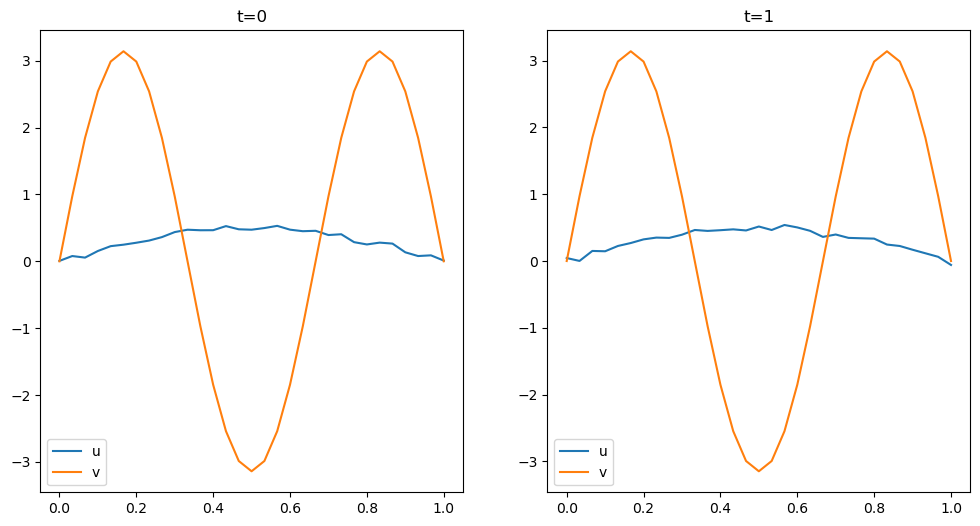

In [ ]:
# plot the u values and v values at t= 0 and t = 10 across the x values
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(x,U[0,:],label='u')
plt.plot(x,V[0,:],label='v')
plt.title('t=0')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,U[1,:],label='u')
plt.plot(x,V[1,:],label='v')
plt.title('t=1')
plt.legend()

plt.show()

Prepare data for training

In [ ]:
# prepare the data from training
u_n_1 = jnp.array(U[0])

v_n_1 = jnp.array(V[0])

u_n = jnp.array([U[1,0],U[1,-1]]).reshape(-1)

# stack the boundary data
y_train = jnp.hstack([u_n,u_n_1,v_n_1]).reshape(-1,1)


In [ ]:
x_train = jnp.hstack([x[0],x[-1], x, x])
t_train = jnp.hstack([jnp.array([1]*(2)),jnp.array([0]*(2*len(x)))])
d_train = jnp.hstack([jnp.array([0,0]),jnp.array([0]*(len(x))), jnp.array([1]*(len(x)))])

# stack t_n and x_n
X_train = jnp.vstack([x_train,t_train,d_train]).T

In [ ]:
dataset_train = gpx.Dataset(X_train, y_train)

In [ ]:

@dataclass(frozen=False)
class WaveKernel(gpx.kernels.AbstractKernel):
    # define the kernel for the u and v values
    kernel_u: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0])
    kernel_v: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0])

    # define the delta_t parameter
    delta_t: ScalarFloat = param_field(jnp.array(dt), trainable = False)
    
    def __call__(
        self, 
        X: Float[Array, "1 D"], 
        Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        
        # use t to track the time
        # i.e. t = 0 is when we are looking at the n_1th time
        # and t = 1 is when we are looking at the nth time
        t = jnp.array(X[1], dtype=int)
        tp = jnp.array(Xp[1], dtype=int)

        # use d to track the spatial dimension
        # i.e. d = 0 is when we are looking at the 1st dimension
        # and d = 1 is when we are looking at the 2nd dimension
        d = jnp.array(X[2], dtype=int)
        dp = jnp.array(Xp[2], dtype=int)

        # only use the first element of the array in calculation
        X = jnp.array(X[0:1],dtype=jnp.float64)
        Xp = jnp.array(Xp[0:1],dtype=jnp.float64) 

        # evaluate the kernel
        k_u = self.kernel_u(X, Xp)
        k_v = self.kernel_v(X, Xp)

        # gradient of the kernel
        # We do not need the gradient of the kernel for the current implementation
        
        # hessian of the kernel
        hess_kernel_u = k_u * ((X-Xp)**2/self.kernel_u.lengthscale**4 - 1/self.kernel_u.lengthscale**2)
        
        # hess_hess_kernel = jnp.array(hessian(hessian(self.kernel))(X, Xp), dtype=jnp.float64)
        hess_hess_kernel_u = k_u * (3/self.kernel_u.lengthscale**4 - 6*(X - Xp)**2/self.kernel_u.lengthscale**6 + (X - Xp)**4/self.kernel_u.lengthscale**8)


        k_n_n_u_u = k_u + 1/4 * self.delta_t**2 * k_v
        k_n_n_u_v = (1/2 * self.delta_t * hess_kernel_u + 
                    1/2 * self.delta_t * k_v)
        k_n_n_v_u = (1/2 * self.delta_t * hess_kernel_u + 
                    1/2 * self.delta_t * k_v)
        
        k_n_n_1_u_u = k_u - 1/4 * self.delta_t**2 * k_v
        k_n_1_n_u_u = k_u - 1/4 * self.delta_t**2 * k_v
        
        k_n_n_1_u_v = (-1/2 * self.delta_t * hess_kernel_u + 
                    1/2 * self.delta_t * k_v)
        k_n_1_n_v_u = (-1/2 * self.delta_t * hess_kernel_u + 
                    1/2 * self.delta_t * k_v)
    
        k_n_n_1_v_u = (1/2 * self.delta_t * hess_kernel_u -
                    1/2 * self.delta_t * k_v)
        k_n_1_n_u_v = (1/2 * self.delta_t * hess_kernel_u -
                    1/2 * self.delta_t * k_v)
        
        k_n_n_v_v = k_v + 1/4 * self.delta_t**2+ hess_hess_kernel_u

        k_n_1_n_v_v = k_v - 1/4 * self.delta_t**2 * hess_hess_kernel_u
        k_n_n_1_v_v = k_v - 1/4 * self.delta_t**2 * hess_hess_kernel_u
        
        k_n_1_n_1_u_u = k_u + 1/4 * self.delta_t**2 * k_v
        k_n_1_n_1_u_v = (-1/2 * self.delta_t * hess_kernel_u -
                        1/2 * self.delta_t * k_v)
        k_n_1_n_1_v_u = (-1/2 * self.delta_t * hess_kernel_u -
                        1/2 * self.delta_t * k_v)
        k_n_1_n_1_v_v = k_v + 1/4 * self.delta_t**2 * hess_hess_kernel_u
        
        
        switch_n_n_u_u = jnp.where((t == 1) & (tp == 1) & (d == 0) & (dp == 0), 1, 0)
        
        switch_n_n_u_v = jnp.where((t == 1) & (tp == 1) & (d == 0) & (dp == 1), 1, 0)
        switch_n_n_v_u = jnp.where((t == 1) & (tp == 1) & (d == 1) & (dp == 0), 1, 0)

        switch_n_n_1_u_u = jnp.where((t == 1) & (tp == 0) & (d == 0) & (dp == 0), 1, 0)
        switch_n_1_n_u_u = jnp.where((t == 0) & (tp == 1) & (d == 0) & (dp == 0), 1, 0)

        switch_n_n_1_u_v = jnp.where((t == 1) & (tp == 0) & (d == 0) & (dp == 1), 1, 0)
        switch_n_1_n_v_u = jnp.where((t == 0) & (tp == 1) & (d == 1) & (dp == 0), 1, 0)
        
        switch_n_n_v_v = jnp.where((t == 1) & (tp == 1) & (d == 1) & (dp == 1), 1, 0)
        
        switch_n_n_1_v_u = jnp.where((t == 1) & (tp == 0) & (d == 1) & (dp == 0), 1, 0)
        switch_n_1_n_u_v = jnp.where((t == 0) & (tp == 1) & (d == 0) & (dp == 1), 1, 0)
        
        switch_n_n_1_v_v = jnp.where((t == 1) & (tp == 0) & (d == 1) & (dp == 1), 1, 0)
        switch_n_1_n_v_v = jnp.where((t == 0) & (tp == 1) & (d == 1) & (dp == 1), 1, 0)

        switch_n_1_n_1_u_u = jnp.where((t == 0) & (tp == 0) & (d == 0) & (dp == 0), 1, 0)
        switch_n_1_n_1_u_v = jnp.where((t == 0) & (tp == 0) & (d == 0) & (dp == 1), 1, 0)
        switch_n_1_n_1_v_u = jnp.where((t == 0) & (tp == 0) & (d == 1) & (dp == 0), 1, 0)
        switch_n_1_n_1_v_v = jnp.where((t == 0) & (tp == 0) & (d == 1) & (dp == 1), 1, 0)

        return_value = (k_n_n_u_u*switch_n_n_u_u+
                k_n_n_1_u_u*switch_n_n_1_u_u+
                k_n_1_n_u_u*switch_n_1_n_u_u+
                k_n_n_1_u_v*switch_n_n_1_u_v+
                k_n_1_n_v_u*switch_n_1_n_v_u+
                k_n_1_n_1_u_u*switch_n_1_n_1_u_u+
                k_n_1_n_1_u_v*switch_n_1_n_1_u_v+
                k_n_1_n_1_v_u*switch_n_1_n_1_v_u+
                k_n_1_n_1_v_v*switch_n_1_n_1_v_v+
                k_n_n_v_v*switch_n_n_v_v+
                k_n_n_v_u*switch_n_n_v_u+
                k_n_n_u_v*switch_n_n_u_v+
                k_n_n_1_v_u*switch_n_n_1_v_u+
                k_n_1_n_u_v*switch_n_1_n_u_v+
                k_n_n_1_v_v*switch_n_n_1_v_v+
                k_n_1_n_v_v*switch_n_1_n_v_v+
                k_n_n_1_v_u*switch_n_n_1_v_u
                ).squeeze()

        return return_value




In [ ]:
#define the mean and kernel functions
mean = gpx.mean_functions.Zero()
kernel = WaveKernel()

# Construct GP prior
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel, jitter = 1e-6)

# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints = n_test * 2 + 2, obs_stddev= np.sqrt(noise))

# Construct the posterior
posterior = prior * likelihood

# define the log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

In [ ]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=dataset_train,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters = 50000,
    key = key,
    safe = False,
    verbose = True
)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# number of test points
n_boundary = 2

In [ ]:
# boundary terms
bt_idx = jnp.linspace(0, len(U[0])-1, n_boundary).astype(int)
idx = jnp.linspace(0, len(x)-1, n_test).astype(int)

# training data
t_train = jnp.hstack([jnp.array([0]*n_test),jnp.array([0]*n_test),jnp.array([1]*n_boundary)]).T
x_train = jnp.hstack([x[idx], x[idx], x[bt_idx]]).T
d_train = jnp.hstack([jnp.array([0]*n_test),jnp.array([1]*n_test),jnp.array([0]*n_boundary)]).T

v_train = jnp.hstack([V[0,idx], V[1,bt_idx]]).reshape(-1,1)
u_train = jnp.hstack([U[0,idx], U[1,bt_idx]]).reshape(-1,1)

# test data 
x_test = jnp.hstack([x[idx], x[idx]])
t_test = jnp.hstack([jnp.array([1]*n_test), jnp.array([1]*n_test)])
d_test = jnp.hstack([jnp.array([0]*n_test), jnp.array([1]*n_test)])
X_test = jnp.vstack([x_test,t_test,d_test]).T
print (x_train.shape, t_train.shape, u_train.shape, v_train.shape)
print (x_test.shape, t_test.shape)

(64,) (64,) (33, 1) (33, 1)
(62,) (62,)


In [ ]:
import time

# intial u0:
u0 = U[0,idx]
v0 = V[0,idx]

# initialize the accumulated uncertainty
updated_std = jnp.array([0]*n_test)

# initialize the covariance matrix
updated_cov = jnp.block([[jnp.eye(n_test) * noise, jnp.zeros((n_test, n_test))],
                        [jnp.zeros((n_test, n_test)), jnp.eye(n_test) * noise]])

# set X_train:
# we are sampling from the same locations every time step, therefore we can set X_train as a constant
X_train = jnp.vstack([x_train, t_train, d_train]).T

# initialize the error
u_mean, v_mean, u_std, v_std, u_true, v_true = [], [], [], [], [], []

for t in range(int(dt * 1000), 1001, int(dt * 1000)):
    # start a timer
    tstart = time.time()

    # u_train is the previous time step u and the boundary conditions
    # u_train = jnp.hstack([u0, U[t,bt_idx].T]).reshape(-1,1)
    u_train = jnp.hstack([u0, v0, jnp.array([0,0])]).reshape(-1,1)

    # create the dataset
    dataset_train = gpx.Dataset(X_train, u_train)

    # train the model
    opt_posterior, history = gpx.fit(
        model=opt_posterior,
        objective=negative_mll,
        train_data=dataset_train,
        optim = ox.adamw(learning_rate=1e-2),
        num_iters = 200,
        key = key,
        verbose = False,
        safe = False 
    )

    latent_dist = opt_posterior.predict_with_prev_cov(X_test, train_data=dataset_train, prev_cov=updated_cov)
    predictive_dist = opt_posterior.likelihood(latent_dist)
    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    predictive_cov = predictive_dist.covariance()

    # only leaves the uncertainty of u
    updated_cov = jnp.block([[predictive_cov[:n_test,:n_test], jnp.zeros((n_test,n_test))],[jnp.zeros((n_test,n_test)), jnp.zeros((n_test,n_test))]])
    updated_std = jnp.sqrt(jnp.diag(updated_cov))

    # the u that is predicted, use this u0 for the next time step
    u0 = predictive_mean[:n_test]
    u0_std = updated_std[:n_test]
    v0 = predictive_mean[n_test:]
    v0_std = updated_std[n_test:]
    
    print (f"Time step {t} is done. Time taken: {time.time() - tstart}")

    # save the results
    u_mean.append(u0)
    v_mean.append(v0)
    u_std.append(u0_std)
    v_std.append(v0_std)
    u_true.append(U_true[t,idx])
    v_true.append(V_true[t,idx])


Time step 1 is done. Time taken: 1.1677801609039307
Time step 2 is done. Time taken: 1.1383421421051025
Time step 3 is done. Time taken: 1.1311421394348145
Time step 4 is done. Time taken: 1.1457431316375732
Time step 5 is done. Time taken: 1.4523930549621582
Time step 6 is done. Time taken: 1.260854959487915
Time step 7 is done. Time taken: 1.7238731384277344
Time step 8 is done. Time taken: 1.5500681400299072
Time step 9 is done. Time taken: 1.5007479190826416
Time step 10 is done. Time taken: 1.316798210144043
Time step 11 is done. Time taken: 1.1290359497070312
Time step 12 is done. Time taken: 1.4684698581695557
Time step 13 is done. Time taken: 1.6553618907928467
Time step 14 is done. Time taken: 2.99871826171875
Time step 15 is done. Time taken: 1.2572369575500488
Time step 16 is done. Time taken: 1.166821002960205
Time step 17 is done. Time taken: 1.145063877105713
Time step 18 is done. Time taken: 1.2975051403045654
Time step 19 is done. Time taken: 1.152466058731079
Time step

In [ ]:
# create the folder
import os

# file name 
foldername = f'Wave_RBF_{n_test}_test_points_{noise}_noise_{dt}_timestep'
folderpath = f'../../result/{foldername}'

if not os.path.exists(folderpath):
    os.makedirs(folderpath)

# save the error, u_mean, u_std, and x
# np.save(f'{folderpath}/error.npy', np.array(error))
np.save(f'{folderpath}/u_mean.npy', np.array(u_mean))
np.save(f'{folderpath}/v_mean.npy', np.array(v_mean))
np.save(f'{folderpath}/u_std.npy', np.array(u_std))
np.save(f'{folderpath}/v_std.npy', np.array(v_std))
np.save(f'{folderpath}/x.npy', np.array(x_test))
np.save(f'{folderpath}/u_true.npy', np.array(u_true))
np.save(f'{folderpath}/v_true.npy', np.array(v_true))

NameError: name 'n_test' is not defined